<a href="https://colab.research.google.com/github/SAIKRISHNA239/Pneumonia_detection/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import transforms
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16, VGG19, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import os
import glob
import cv2
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers  # Added optimizers here
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [9]:
# dataset_path = './chest-xray'
dataset_path = '/content/drive/MyDrive/chest-xray'

In [10]:
data_dir = "/content/drive/MyDrive/chest-xray"
batch_size = 32
img_height, img_width = 224, 224

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f"{data_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    f"{data_dir}/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    f"{data_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5857 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


In [11]:
def create_model(base_model):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    return model


In [12]:
def extract_features(generator, model, sample_count):
    features = np.zeros(shape=(sample_count, model.output_shape[1]))  # Adjust based on model output shape
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


In [13]:
base_models = [
    ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)),
    EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
]

for i, base_model in enumerate(base_models):
    print(f"Training model {i+1}")
    model = create_model(base_model)
    model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=2)

    base_model_for_rf = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    model_for_rf = models.Sequential([
        base_model_for_rf,
        layers.GlobalAveragePooling2D()
    ])

    # Extract features from images
    train_features, train_labels = extract_features(train_generator, model_for_rf, train_generator.samples)
    validation_features, validation_labels = extract_features(validation_generator, model_for_rf, validation_generator.samples)
    test_features, test_labels = extract_features(test_generator, model_for_rf, test_generator.samples)


    # Prediction
    y_true = test_generator.classes
    y_pred = np.round(model.predict(test_generator)).astype(int).flatten()

    # Evaluation
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Model {i+1}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}\n")


Training model 1
Epoch 1/5
184/184 - 142s - loss: 0.1586 - accuracy: 0.9489 - val_loss: 6.3920 - val_accuracy: 0.5000 - 142s/epoch - 774ms/step
Epoch 2/5
184/184 - 80s - loss: 0.0518 - accuracy: 0.9805 - val_loss: 9.8708 - val_accuracy: 0.5000 - 80s/epoch - 433ms/step
Epoch 3/5
184/184 - 78s - loss: 0.0648 - accuracy: 0.9771 - val_loss: 1221.5629 - val_accuracy: 0.5000 - 78s/epoch - 424ms/step
Epoch 4/5
184/184 - 79s - loss: 0.0880 - accuracy: 0.9665 - val_loss: 1.0935 - val_accuracy: 0.6875 - 79s/epoch - 429ms/step
Epoch 5/5
184/184 - 78s - loss: 0.0459 - accuracy: 0.9828 - val_loss: 0.0500 - val_accuracy: 1.0000 - 78s/epoch - 425ms/step
22/22 [==============================] - 8s 310ms/step
Model 1: Accuracy: 0.7982456140350878, Precision: 0.7616487455197133, Recall: 0.9883720930232558, F1 Score: 0.8603238866396762

Training model 2
Epoch 1/5
184/184 - 118s - loss: 0.1222 - accuracy: 0.9542 - val_loss: 0.9665 - val_accuracy: 0.5625 - 118s/epoch - 640ms/step
Epoch 2/5
184/184 - 76s - 

In [17]:
# Normalize the extracted features
scaler = MinMaxScaler().fit(train_features)
train_features = scaler.transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Predict and Evaluate the Random Forest Classifier
predictions = rf_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"\nRandom Forest: Accuracy: {accuracy:.2f}, Precision: {precision:.2f},recall:{recall:.2f} ,f1 score:{f1:2f}")



Random Forest: Accuracy: 0.80, Precision: 0.76,recall:0.98 ,f1 score:0.858883


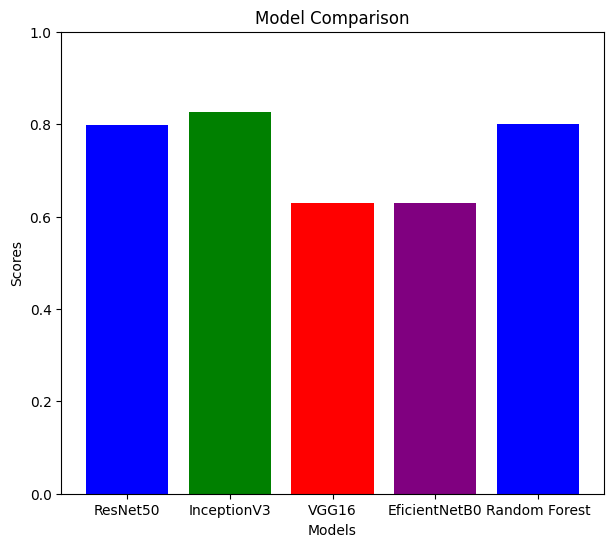

In [19]:
import matplotlib.pyplot as plt
model_names = ['ResNet50', 'InceptionV3', 'VGG16', 'EficientNetB0','Random Forest']
accuracy_scores = [ 0.7982, 0.8260, 0.6286, 0.6286, 0.80]
scores = accuracy_scores
plt.figure(figsize=(7, 6))
plt.bar(model_names, scores, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.0)  # Set the y-axis limits (accuracy scores typically range from 0 to 1)
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.show()